In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
import warnings
import copy
from torch.optim import AdamW

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def seedEverything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seedEverything()

anger        808
fear        3860
joy         1660
sadness     2171
surprise    1999
dtype: int64


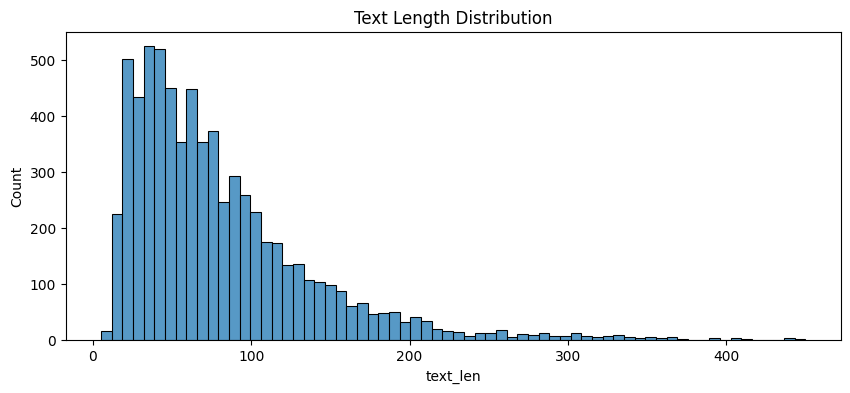

In [4]:
trainDf = pd.read_csv('train.csv')
testDf = pd.read_csv('test.csv')
sampleSub = pd.read_csv('sample_submission.csv')

labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']

print(trainDf[labels].sum())
trainDf['text_len'] = trainDf['text'].apply(len)
plt.figure(figsize=(10, 4))
sns.histplot(trainDf['text_len'])
plt.title('Text Length Distribution')
plt.show()

In [5]:
X = trainDf['text'].values
y = trainDf[labels].values

XTrain, XVal, yTrain, yVal = train_test_split(X, y, test_size=0.1, random_state=42)

def computeMacroF1(preds, targets):
    return f1_score(targets, preds, average='macro')

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.bestScore = -np.inf
        self.counter = 0
        self.earlyStop = False
        self.bestState = None
        self.bestEpoch = 0

    def __call__(self, score, model, epoch):
        if score > self.bestScore + self.delta:
            self.bestScore = score
            self.bestState = copy.deepcopy(model.state_dict())
            self.bestEpoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.earlyStop = True

In [6]:
# Classical Baseline
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
XTrainTfidf = vectorizer.fit_transform(XTrain)
XValTfidf = vectorizer.transform(XVal)

clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
clf.fit(XTrainTfidf, yTrain)

yPred = clf.predict(XValTfidf)
baselineScore = computeMacroF1(yPred, yVal)
print(f"Classical ML (TF-IDF + LR) Macro F1: {baselineScore:.4f}")

bestModelName = "Classical"
bestValScore = baselineScore
bestEpochs = 0

Classical ML (TF-IDF + LR) Macro F1: 0.4391


In [7]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, maxLen=64, type='nn', vocab=None):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.maxLen = maxLen
        self.type = type
        self.vocab = vocab

        if (self.type == 'nn' or self.type == 'rnn') and self.vocab is None:
            self.buildVocab()

    def buildVocab(self):
        wordSet = set()
        for t in self.texts:
            for w in t.lower().split():
                wordSet.add(w)
        self.vocab = {w: i+1 for i, w in enumerate(wordSet)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        if self.type == 'transformer':
            enc = self.tokenizer.encode_plus(
                text, add_special_tokens=True, max_length=self.maxLen,
                padding='max_length', truncation=True, return_tensors='pt'
            )
            item = {
                'ids': enc['input_ids'].flatten(),
                'mask': enc['attention_mask'].flatten()
            }
        else:
            words = text.lower().split()
            vec = [self.vocab.get(w, 0) for w in words][:self.maxLen]
            if len(vec) < self.maxLen:
                vec += [0] * (self.maxLen - len(vec))
            item = {'ids': torch.tensor(vec, dtype=torch.long)}

        if self.labels is not None:
            item['targets'] = torch.tensor(self.labels[idx], dtype=torch.float)

        return item

def trainFn(model, loader, optimizer, criterion):
    model.train()
    totalLoss = 0
    for data in loader:
        ids = data['ids'].to(device)
        targets = data['targets'].to(device)
        mask = data['mask'].to(device) if 'mask' in data else None

        optimizer.zero_grad()
        output = model(ids, mask) if mask is not None else model(ids)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        totalLoss += loss.item()
    return totalLoss / len(loader)

def evalFn(model, loader):
    model.eval()
    finTargets, finOutputs = [], []
    with torch.no_grad():
        for data in loader:
            ids = data['ids'].to(device)
            targets = data['targets'].to(device)
            mask = data['mask'].to(device) if 'mask' in data else None
            output = model(ids, mask) if mask is not None else model(ids)
            finTargets.extend(targets.cpu().numpy())
            finOutputs.extend(torch.sigmoid(output).cpu().numpy())
    return computeMacroF1(np.array(finOutputs) >= 0.5, np.array(finTargets))

In [8]:
# Simple NN
class SimpleNN(nn.Module):
    def __init__(self, vocabSize, embedDim, numClasses):
        super(SimpleNN, self).__init__()
        self.embedding = nn.Embedding(vocabSize, embedDim)
        self.fc = nn.Linear(embedDim, numClasses)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = x.mean(dim=1)
        return self.fc(x)

trainDsNN = EmotionDataset(XTrain, yTrain, type='nn')
valDsNN = EmotionDataset(XVal, yVal, type='nn', vocab=trainDsNN.vocab)
trainLoaderNN = DataLoader(trainDsNN, batch_size=32, shuffle=True)
valLoaderNN = DataLoader(valDsNN, batch_size=32)

modelNN = SimpleNN(len(trainDsNN.vocab)+1, 100, 5).to(device)
optimizer = optim.Adam(modelNN.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
es = EarlyStopping(patience=10)

print("Training Simple NN...")
for epoch in range(100):
    loss = trainFn(modelNN, trainLoaderNN, optimizer, criterion)
    f1 = evalFn(modelNN, valLoaderNN)
    print(f"Epoch {epoch+1} F1: {f1:.4f}")
    es(f1, modelNN, epoch)
    if es.earlyStop:
        print("Early Stopping")
        break

if es.bestScore > bestValScore:
    bestValScore = es.bestScore
    bestModelName = "SimpleNN"
    bestEpochs = es.bestEpoch + 1
    bestVocab = trainDsNN.vocab

Training Simple NN...
Epoch 1 F1: 0.1490
Epoch 2 F1: 0.1514
Epoch 3 F1: 0.1514
Epoch 4 F1: 0.1547
Epoch 5 F1: 0.1550
Epoch 6 F1: 0.1607
Epoch 7 F1: 0.1602
Epoch 8 F1: 0.1745
Epoch 9 F1: 0.1784
Epoch 10 F1: 0.2194
Epoch 11 F1: 0.2635
Epoch 12 F1: 0.2323
Epoch 13 F1: 0.2550
Epoch 14 F1: 0.2967
Epoch 15 F1: 0.3002
Epoch 16 F1: 0.3468
Epoch 17 F1: 0.3429
Epoch 18 F1: 0.3765
Epoch 19 F1: 0.3621
Epoch 20 F1: 0.4227
Epoch 21 F1: 0.4101
Epoch 22 F1: 0.4371
Epoch 23 F1: 0.4577
Epoch 24 F1: 0.4590
Epoch 25 F1: 0.4693
Epoch 26 F1: 0.4974
Epoch 27 F1: 0.4919
Epoch 28 F1: 0.4929
Epoch 29 F1: 0.5138
Epoch 30 F1: 0.5182
Epoch 31 F1: 0.5225
Epoch 32 F1: 0.5261
Epoch 33 F1: 0.5439
Epoch 34 F1: 0.5547
Epoch 35 F1: 0.5737
Epoch 36 F1: 0.5668
Epoch 37 F1: 0.5847
Epoch 38 F1: 0.5598
Epoch 39 F1: 0.5879
Epoch 40 F1: 0.6022
Epoch 41 F1: 0.6070
Epoch 42 F1: 0.6091
Epoch 43 F1: 0.6167
Epoch 44 F1: 0.6305
Epoch 45 F1: 0.6493
Epoch 46 F1: 0.6437
Epoch 47 F1: 0.6356
Epoch 48 F1: 0.6658
Epoch 49 F1: 0.6562
Epoch 5

In [9]:
# RNN (LSTM)
class RNNModel(nn.Module):
    def __init__(self, vocabSize, embedDim, hiddenDim, numClasses):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocabSize, embedDim)
        self.lstm = nn.LSTM(embedDim, hiddenDim, batch_first=True)
        self.fc = nn.Linear(hiddenDim, numClasses)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

modelRNN = RNNModel(len(trainDsNN.vocab)+1, 100, 64, 5).to(device)
optimizer = optim.Adam(modelRNN.parameters(), lr=1e-3)
es = EarlyStopping(patience=10)

print("Training LSTM...")
for epoch in range(100):
    loss = trainFn(modelRNN, trainLoaderNN, optimizer, criterion)
    f1 = evalFn(modelRNN, valLoaderNN)
    print(f"Epoch {epoch+1} F1: {f1:.4f}")
    es(f1, modelRNN, epoch)
    if es.earlyStop:
        print("Early Stopping")
        break

if es.bestScore > bestValScore:
    bestValScore = es.bestScore
    bestModelName = "LSTM"
    bestEpochs = es.bestEpoch + 1
    bestVocab = trainDsNN.vocab

Training LSTM...
Epoch 1 F1: 0.1493
Epoch 2 F1: 0.1516
Epoch 3 F1: 0.1516
Epoch 4 F1: 0.1516
Epoch 5 F1: 0.1555
Epoch 6 F1: 0.1578
Epoch 7 F1: 0.1559
Epoch 8 F1: 0.2736
Epoch 9 F1: 0.2722
Epoch 10 F1: 0.2910
Epoch 11 F1: 0.2984
Epoch 12 F1: 0.2965
Epoch 13 F1: 0.3009
Epoch 14 F1: 0.2888
Epoch 15 F1: 0.3006
Epoch 16 F1: 0.2823
Epoch 17 F1: 0.3527
Epoch 18 F1: 0.3917
Epoch 19 F1: 0.4375
Epoch 20 F1: 0.4867
Epoch 21 F1: 0.5028
Epoch 22 F1: 0.5184
Epoch 23 F1: 0.5605
Epoch 24 F1: 0.5781
Epoch 25 F1: 0.5663
Epoch 26 F1: 0.5571
Epoch 27 F1: 0.6037
Epoch 28 F1: 0.5921
Epoch 29 F1: 0.6151
Epoch 30 F1: 0.6051
Epoch 31 F1: 0.6106
Epoch 32 F1: 0.6181
Epoch 33 F1: 0.6301
Epoch 34 F1: 0.6321
Epoch 35 F1: 0.6432
Epoch 36 F1: 0.6426
Epoch 37 F1: 0.6410
Epoch 38 F1: 0.6425
Epoch 39 F1: 0.6496
Epoch 40 F1: 0.6471
Epoch 41 F1: 0.6451
Epoch 42 F1: 0.6575
Epoch 43 F1: 0.6554
Epoch 44 F1: 0.6553
Epoch 45 F1: 0.6525
Epoch 46 F1: 0.6630
Epoch 47 F1: 0.6602
Epoch 48 F1: 0.6690
Epoch 49 F1: 0.6553
Epoch 50 F1:

In [ ]:
# Transformer (RoBERTa)
class TransformerModel(nn.Module):
    def __init__(self, modelName='roberta-base', numClasses=5):
        super(TransformerModel, self).__init__()
        self.bert = AutoModel.from_pretrained(modelName)
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(768, numClasses)

    def forward(self, ids, mask):
        out = self.bert(ids, attention_mask=mask)
        return self.fc(self.drop(out.pooler_output))

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
trainDsTrans = EmotionDataset(XTrain, yTrain, tokenizer=tokenizer, type='transformer')
valDsTrans = EmotionDataset(XVal, yVal, tokenizer=tokenizer, type='transformer')
trainLoaderTrans = DataLoader(trainDsTrans, batch_size=16, shuffle=True)
valLoaderTrans = DataLoader(valDsTrans, batch_size=16)

modelTrans = TransformerModel().to(device)
optimizer = AdamW(modelTrans.parameters(), lr=2e-5)
totalSteps = len(trainLoaderTrans) * 100
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=totalSteps)
es = EarlyStopping(patience=5) 

print("Training RoBERTa...")
for epoch in range(100):
    loss = trainFn(modelTrans, trainLoaderTrans, optimizer, criterion)
    f1 = evalFn(modelTrans, valLoaderTrans)
    print(f"Epoch {epoch+1} F1: {f1:.4f}")
    es(f1, modelTrans, epoch)
    if es.earlyStop:
        print("Early Stopping")
        break

if es.bestScore > bestValScore:
    bestValScore = es.bestScore
    bestModelName = "Transformer"
    bestEpochs = es.bestEpoch + 1

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training RoBERTa...
Epoch 1 F1: 0.7307
Epoch 2 F1: 0.7962
Epoch 3 F1: 0.8356
Epoch 4 F1: 0.8475
Epoch 5 F1: 0.8586
Epoch 6 F1: 0.8620
Epoch 7 F1: 0.8661
Epoch 8 F1: 0.8713
Epoch 9 F1: 0.8596
Epoch 10 F1: 0.8630
Epoch 11 F1: 0.8623
Epoch 12 F1: 0.8693
Epoch 13 F1: 0.8598
Early Stopping


In [ ]:
# Final retraining on complete dataset for the submission
print(f"Best Model: {bestModelName} (Score: {bestValScore:.4f})")
print(f"Retraining on full data for {bestEpochs} epochs...")

fullX = trainDf['text'].values
fullY = trainDf[labels].values
testX = testDf['text'].values

if bestModelName == "Classical":
    vec = TfidfVectorizer(max_features=5000, stop_words='english')
    fullXTfidf = vec.fit_transform(fullX)
    testXTfidf = vec.transform(testX)

    finalClf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
    finalClf.fit(fullXTfidf, fullY)
    finalPreds = finalClf.predict(testXTfidf)

else:
    if bestModelName == "Transformer":
        fullDs = EmotionDataset(fullX, fullY, tokenizer=tokenizer, type='transformer')
        testDs = EmotionDataset(testX, tokenizer=tokenizer, type='transformer')
        finalModel = TransformerModel().to(device)
        batchSize = 16
        lr = 2e-5
        opt = AdamW(finalModel.parameters(), lr=lr)
    else:
        fullDs = EmotionDataset(fullX, fullY, type='nn', vocab=bestVocab)
        testDs = EmotionDataset(testX, type='nn', vocab=bestVocab)
        if bestModelName == "SimpleNN":
            finalModel = SimpleNN(len(bestVocab)+1, 100, 5).to(device)
        else: # LSTM
            finalModel = RNNModel(len(bestVocab)+1, 100, 64, 5).to(device)
        batchSize = 32
        lr = 1e-3
        opt = optim.Adam(finalModel.parameters(), lr=lr)

    fullLoader = DataLoader(fullDs, batch_size=batchSize, shuffle=True)
    testLoader = DataLoader(testDs, batch_size=batchSize, shuffle=False)

    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(bestEpochs):
        loss = trainFn(finalModel, fullLoader, opt, criterion)
        print(f"Retrain Epoch {epoch+1} Loss: {loss:.4f}")

    finalModel.eval()
    predsList = []
    with torch.no_grad():
        for data in testLoader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device) if 'mask' in data else None
            out = finalModel(ids, mask) if mask is not None else finalModel(ids)
            predsList.extend(torch.sigmoid(out).cpu().numpy())

    finalPreds = (np.array(predsList) >= 0.5).astype(int)

# Submission CSV Generation
sub = pd.DataFrame(finalPreds, columns=labels)
sub['id'] = testDf['id']
sub = sub[['id'] + labels]
sub.to_csv('submission.csv', index=False)
print("Submission Generated")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best Model: Transformer (Score: 0.8713)
Retraining on full data for 8 epochs...
Retrain Epoch 1 Loss: 0.4230
Retrain Epoch 2 Loss: 0.2743
Retrain Epoch 3 Loss: 0.1874
Retrain Epoch 4 Loss: 0.1281
Retrain Epoch 5 Loss: 0.0854
Retrain Epoch 6 Loss: 0.0620
Retrain Epoch 7 Loss: 0.0491
Retrain Epoch 8 Loss: 0.0384
Submission Generated


In [13]:
torch.save(finalModel.state_dict(), 'roberta_emotion_model.pth')
tokenizer.save_pretrained('./roberta_emotion_tokenizer')

('./roberta_emotion_tokenizer/tokenizer_config.json',
 './roberta_emotion_tokenizer/special_tokens_map.json',
 './roberta_emotion_tokenizer/vocab.json',
 './roberta_emotion_tokenizer/merges.txt',
 './roberta_emotion_tokenizer/added_tokens.json',
 './roberta_emotion_tokenizer/tokenizer.json')